# Interferon beta stim and genetic perturbations cause changes in gene-gene correlation

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [105]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [8]:
data_path = '/data/parameter_estimation/'

### Plotting function

In [9]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Read the IFN AnnData object

In [10]:
ifn_adata = sc.read(data_path + 'interferon_data/interferon.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Function for summarizing DC results

In [84]:
def organize_dc_result(result, adata, ct):
    
    idxs_1 = result['gene_idx_1']
    idxs_2 = result['gene_idx_2']
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            result['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_pval'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_fdr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
        columns=['gene_1', 'gene_2', 'corr_1', 'corr_2', 'pval', 'fdr'])
    df['ct'] = ct
    
    return df

def organize_2d_ci_result(ci_dict, adata, idxs_1, idxs_2, ct):
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            ci_dict[ct + ' - ctrl']['corr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            ci_dict[ct + ' - stim']['corr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]]
        )),
        columns=['gene_1', 'gene_2', 'corr_ci_1', 'corr_ci_2'])
    df['ct'] = ct
    
    return df

In [85]:
idxs_1 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
organize_2d_ci_result(ifn_corr_ci, ifn_adata, idxs_1, idxs_2, ct)

,gene_1,gene_2,corr_ci_1,corr_ci_2,ct
0,ZNF24,KIF22,0.106396,0.073235,CD4 T cells
1,ZNF24,CPNE3,0.053312,0.080912,CD4 T cells
2,ZNF24,TESPA1,0.102368,0.086256,CD4 T cells
3,ZNF24,LST1,0.073748,0.062809,CD4 T cells
4,ZNF24,IRAK4,0.055953,0.098673,CD4 T cells
...,...,...,...,...,...
10954,ATF4,SEC14L1,0.100092,0.080802,CD4 T cells
10955,ATF4,DYNC1LI1,0.059812,0.057968,CD4 T cells
10956,ATF4,EZR,0.086573,0.052088,CD4 T cells
10957,ATF4,MAPK1,0.059283,0.083105,CD4 T cells


### Find a candidate

ID2 and IFI6, only significant in T cells

In [12]:
ct = 'CD4 T cells'

In [13]:
with open(data_path + 'interferon_data/stim_effect_1d_moments.pkl', 'rb') as f:
    ifn_moment_dict_1d = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_2d.pkl', 'rb') as f:
    ifn_dc_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_1d.pkl', 'rb') as f:
    ifn_de_dv_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_ci_2d.pkl', 'rb') as f:
    ifn_corr_ci = pkl.load(f)

In [116]:
ifn_dc_df = \
    pd.concat([organize_dc_result(ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata, ct) for ct in ifn_adata.obs.cell.drop_duplicates().tolist() if ct != 'Megakaryocytes' and ct != 'NK cells'])\
    .query('corr_1 < 1 & corr_2 < 1 & corr_1 > -1 & corr_2 > -1')
ifn_dc_df_sig = ifn_dc_df.query('fdr < 0.2')

In [117]:
gene_pair_by_ct = ifn_dc_df_sig\
    .groupby(['gene_1', 'gene_2'])\
    .agg({
        'ct':set,
        'corr_1':set,
        'corr_2':set})\
    .reset_index()
gene_pair_by_ct['ct_count'] = gene_pair_by_ct['ct'].apply(len)

In [118]:
gene_pair_by_ct[gene_pair_by_ct['ct'] == set(['CD4 T cells', 'CD8 T cells'])].head(100)

,gene_1,gene_2,ct,corr_1,corr_2,ct_count
763,ID2,IFI6,"{CD4 T cells, CD8 T cells}","{-0.032016608261336406, -0.015400314978196052}","{-0.27957039777071213, -0.5434750453216938}",2


In [119]:
ifn_dc_df.query('gene_1 == "ID2" & gene_2 == "IFI6"')

,gene_1,gene_2,corr_1,corr_2,pval,fdr,ct
9917,ID2,IFI6,-0.067744,-0.230050,1.591841e-01,0.668393,CD14+ Monocytes
9917,ID2,IFI6,-0.032017,-0.279570,4.028149e-08,0.000110,CD4 T cells
9917,ID2,IFI6,0.300576,-0.072070,1.471853e-01,0.777451,Dendritic cells
9917,ID2,IFI6,-0.015400,-0.543475,1.999800e-04,0.036457,CD8 T cells
9917,ID2,IFI6,-0.017080,0.069227,2.087791e-01,0.686799,B cells
9917,ID2,IFI6,-0.076421,0.182613,8.373163e-01,0.973358,FCGR3A+ Monocytes


### Bar plot

In [120]:
idxs_1 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
ci_df = pd.concat([organize_2d_ci_result(ifn_corr_ci, ifn_adata, idxs_1, idxs_2, ct) for ct in ifn_adata.obs.cell.drop_duplicates().tolist() if ct != 'Megakaryocytes' and ct != 'NK cells'])

In [141]:
gene_1 = 'ID2'
gene_2 = 'IFI6'
ct_corr_info = ifn_dc_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['ct'].tolist()
ctrl_corrs = ifn_dc_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_1'].tolist()
ctrl_ci = ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_ci_1'].tolist()
stim_corrs = ifn_dc_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_2'].tolist()
stim_ci = ci_df.query('gene_1 == "{}" & gene_2 == "{}"'.format(gene_1, gene_2))['corr_ci_2'].tolist()

barwidth = 0.3
ctrl_loc = np.arange(len(ct_corr_info)) - barwidth/2
stim_loc = np.arange(len(ct_corr_info)) + barwidth/2

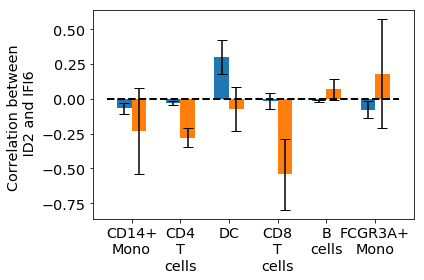

In [242]:
plt.figure(figsize=(6, 4))
plt.bar(
    ctrl_loc, 
    ctrl_corrs, 
    width=barwidth,
    yerr=ctrl_ci,
    capsize=5
);

plt.bar(
    stim_loc, 
    stim_corrs, 
    width=barwidth,
    yerr=stim_ci,
    capsize=5
);

plt.plot([-0.5, len(stim_loc)-0.5], [0, 0], '--', lw=2, color='k');

labels = ['CD14+\nMono',
 'CD4\nT\ncells',
 'DC',
 'CD8\nT\ncells',
 'B\ncells',
 'FCGR3A+\nMono']

plt.xticks(np.arange(len(stim_loc)), labels);
plt.ylabel('Correlation between \n ID2 and IFI6');
plt.tight_layout()
plt.savefig(data_path + 'figures/fig3/ID2_IFI6_across_ct.pdf')


### Scatter plots

In [210]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0, ax=plt):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    ax.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    

def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order, ax=plt):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 7, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    ax.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    ax.plot(x_range, line, color=sns.color_palette()[color_order])

In [163]:
cd4_ctrl_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD4 T cells - ctrl'][:, ['ID2', 'IFI6']].X.toarray()
cd4_stim_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD4 T cells - stim'][:, ['ID2', 'IFI6']].X.toarray()

cd8_ctrl_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD8 T cells - ctrl'][:, ['ID2', 'IFI6']].X.toarray()
cd8_stim_data = ifn_adata[ifn_adata.obs['cell_type'] == 'CD8 T cells - stim'][:, ['ID2', 'IFI6']].X.toarray()

In [197]:
gene_1_idx = ifn_adata.var.loc['ID2', :]['gene_idx']
gene_2_idx = ifn_adata.var.loc['IFI6', :]['gene_idx']

In [199]:
ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_1_idx]

1.2068241

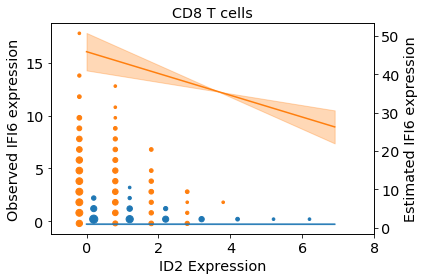

In [243]:
fig, ax1 = plt.subplots()

plot_2d_discrete(cd8_ctrl_data, offset=0.2, ax=ax1)
plot_2d_discrete(cd8_stim_data, offset=-0.2, ax=ax1)

ax2 = ax1.twinx()
line_from_correlation(
    corr=ctrl_corrs[3],
    corr_ci=ctrl_ci[3],
    x=cd8_ctrl_data[:, 0],
    y=cd8_ctrl_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD8 T cells - ctrl']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD8 T cells - ctrl']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD8 T cells - ctrl']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD8 T cells - ctrl']['second'][gene_2_idx],
    color_order=0,
    ax=ax2
    )

line_from_correlation(
    corr=stim_corrs[3],
    corr_ci=stim_ci[3],
    x=cd8_stim_data[:, 0],
    y=cd8_stim_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD8 T cells - stim']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD8 T cells - stim']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD8 T cells - stim']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD8 T cells - stim']['second'][gene_2_idx],
    color_order=1,
    ax=ax2
    )

ax1.set_xlim(-1,8);
ax1.set_xlabel('ID2 Expression');
ax1.set_ylabel('Observed IFI6 expression');
ax2.set_ylabel('Estimated IFI6 expression');
ax1.set_title('CD8 T cells')

fig.tight_layout()

fig.savefig(data_path + 'figures/fig3/CD8_ID2_IFI6.pdf')


Text(0.5, 1.0, 'CD4 T cells')

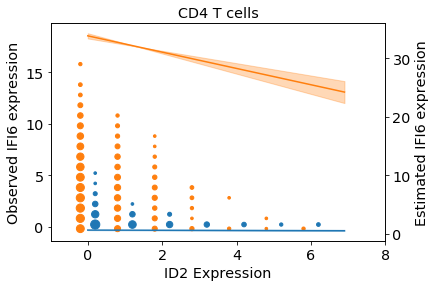

In [237]:
fig, ax1 = plt.subplots()

plot_2d_discrete(cd4_ctrl_data, offset=0.2, ax=ax1)
plot_2d_discrete(cd4_stim_data, offset=-0.2, ax=ax1)

ax2 = ax1.twinx()
line_from_correlation(
    corr=ctrl_corrs[1],
    corr_ci=ctrl_ci[1],
    x=cd4_ctrl_data[:, 0],
    y=cd4_ctrl_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD4 T cells - ctrl']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD4 T cells - ctrl']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD4 T cells - ctrl']['second'][gene_2_idx],
    color_order=0,
    ax=ax2
    )

line_from_correlation(
    corr=stim_corrs[1],
    corr_ci=stim_ci[1],
    x=cd4_stim_data[:, 0],
    y=cd4_stim_data[:, 1],
    mu_x=ifn_moment_dict_1d['CD4 T cells - stim']['first'][gene_1_idx],
    mu_y=ifn_moment_dict_1d['CD4 T cells - stim']['first'][gene_2_idx],
    sigma_x=ifn_moment_dict_1d['CD4 T cells - stim']['second'][gene_1_idx],
    sigma_y=ifn_moment_dict_1d['CD4 T cells - stim']['second'][gene_2_idx],
    color_order=1,
    ax=ax2
    )

ax1.set_xlim(-1,8);
ax1.set_xlabel('ID2 Expression');
ax1.set_ylabel('Observed IFI6 expression');
ax2.set_ylabel('Estimated IFI6 expression');
ax1.set_title('CD4 T cells')